In [1]:
import torch
import torch.nn as nn
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dtype = torch.float

In [2]:
def norm_sigmoid(tensor):
    """maps real line to interval ]-1; 1[ """
    return 2*torch.sigmoid(tensor) - 1

In [3]:
# read in data
r_hat = torch.load('tensor_data/r_hat-torch.th')
s_hat = torch.load('tensor_data/s_hat-torch.th')
b = torch.load('tensor_data/b_DNS-torch.th')
grid = torch.load('tensor_data/grid-torch.th')

# N is number of input point, D_in is input size, D_out is output size, H is hidden dimension
N = r_hat.shape[0]
D_in, D_out = 5, 10
H = 200

In [4]:
# initialize feature set (invariants)
inv = torch.zeros(N, 5, dtype=dtype, requires_grad=False) #

# compute feature set
inv[:,0] = torch.from_numpy(np.array(s_hat.matmul(s_hat)).trace(axis1=1, axis2=2))
inv[:,1] = torch.from_numpy(np.array(r_hat.matmul(r_hat)).trace(axis1=1, axis2=2))
inv[:,2] = torch.from_numpy(np.array(s_hat.matmul(s_hat.matmul(s_hat))).trace(axis1=1, axis2=2))
inv[:,3] = torch.from_numpy(np.array(r_hat.matmul(r_hat.matmul(s_hat))).trace(axis1=1, axis2=2))
inv[:,4] = torch.from_numpy(np.array(r_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat)))).trace(axis1=1, axis2=2))

# normalize feature set
inv_scaled = norm_sigmoid(inv)
# inv_scaled.requires_grad=True

#### Basis tensors:


\begin{align}
    T_1 &= \hat S \\
    T_2 &= \hat S \hat \Omega - \hat \Omega \hat S \\
    T_3 &= \hat S^2 - \frac{1}{3} \mathrm{tr} (\hat S^2)I \\
    T_4 &= \hat \Omega^2 - \frac{1}{3} \mathrm{tr} (\hat \Omega^2)I\\
    T_5 &= \hat \Omega \hat S^2 - \hat S^2 \Omega \\
    T_6 &= \hat \Omega^2 \hat S + \hat S \hat \Omega^2 - \frac{2}{3} \mathrm{tr} (\hat S \hat \Omega^2)I \\
    T_7 &= \hat \Omega \hat S \hat \Omega^2 - \hat \Omega^2 \hat S \hat \Omega \\
    T_8 &= \hat S \hat \Omega \hat S^2 - \hat S^2 \hat \Omega \hat S \\
    T_9 &= \hat \Omega^2 \hat S^2 + \hat S^2 \hat \Omega^2 - \frac{2}{3} \mathrm{tr} (\hat S^2 \hat \Omega^2)I \\
    T_{10} &= \hat \Omega \hat S^2 \hat \Omega^2 - \hat \Omega^2 \hat S^2 \hat \Omega
\end{align}

In [5]:
# initialize tensor basis
T = torch.zeros(N, 10, 9, dtype=dtype, requires_grad=False)

# compute tensor basis
T[:,0,:] = s_hat.flatten(1)  # s_hat
T[:,1,:] = (s_hat.matmul(r_hat) - r_hat.matmul(s_hat)).flatten(1)
T[:,2,:] = (s_hat.matmul(s_hat) - 1/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)* \
            inv[:,0].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
T[:,3,:] = (r_hat.matmul(r_hat) - 1/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)* \
            inv[:,1].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
T[:,4,:] = (r_hat.matmul(s_hat.matmul(s_hat)) - s_hat.matmul(s_hat.matmul(r_hat))).flatten(1)
T[:,5,:] = (r_hat.matmul(s_hat.matmul(s_hat)) - s_hat.matmul(s_hat.matmul(r_hat))
            - 2/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)*inv[:,3].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
T[:,6,:] = (r_hat.matmul(s_hat.matmul(r_hat.matmul(r_hat))) - r_hat.matmul(r_hat.matmul(s_hat.matmul(r_hat)))).flatten(1)
T[:,7,:] = (s_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat))) - s_hat.matmul(s_hat.matmul(r_hat.matmul(s_hat)))).flatten(1)
T[:,8,:] = (r_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat))) + s_hat.matmul(s_hat.matmul(r_hat.matmul(r_hat)))
       - 2/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)*inv[:,4].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
T[:,9,:] = (r_hat.matmul(s_hat.matmul(s_hat.matmul(r_hat.matmul(r_hat)))) \
            - r_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat.matmul(r_hat))))).flatten(1)

# normalize tensor basis by spectral norm
for i in range(T.shape[1]):
    T[:,i,:] = T[:,i,:] / torch.tensor(la.norm(T[:,i,:].reshape(-1,3,3), ord=2, axis=(1,2))).unsqueeze(1).expand(N,9)

In [6]:
class TBNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TBNN, self).__init__()
        self.input_layer = torch.nn.Linear(D_in, H)
#         self.hidden_layer_1 = torch.nn.Linear(H, H)
#         self.hidden_layer_2 = torch.nn.Linear(H, H)
#         self.hidden_layer_3 = torch.nn.Linear(H, 100)
#         self.hidden_layer_4 = torch.nn.Linear(H, H)
        self.hidden_layer_5 = torch.nn.Linear(H, 100)
        self.hidden_layer_6 = torch.nn.Linear(100, 25)
        self.output_linear = torch.nn.Linear(25, D_out)
        self.NN = torch.nn.Sequential(self.input_layer,
                                      torch.nn.LeakyReLU(),
#                                       self.hidden_layer_1,
#                                       torch.nn.LeakyReLU(),
#                                       self.hidden_layer_2,
#                                       torch.nn.LeakyReLU(),
#                                       self.hidden_layer_3,
#                                       torch.nn.LeakyReLU(),
#                                       self.hidden_layer_4,
#                                       torch.nn.LeakyReLU(),
                                      self.hidden_layer_5,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_6,
                                      torch.nn.Tanh(),
                                      self.output_linear)
    def forward(self, inv, T):
        G = self.NN(inv).unsqueeze(2).expand(inv.shape[0],10,9)
        return (G*T).sum(dim=1)

In [7]:
# create model instance
model = TBNN(D_in, H, D_out)
loss_fn = torch.nn.MSELoss(reduction='sum')

# reshape b tensor
b = b.flatten(1).clone().float()
b.requires_grad = False

# split data into training and test data
inv_train, inv_test, T_train, T_test, b_train, b_test = train_test_split(inv_scaled, T, b,
                                                                         test_size=0.33, random_state=42)
inv_train.requires_grad=True

## L2 regularization
lmbda = 1e-3 # reg. constant 
def L2loss(lmbda, net):
    reg = torch.tensor(0.)
    for m in net.modules():
        if hasattr(m, 'weight'):
            reg += m.weight.norm()**2
    return lmbda*reg

In [8]:
# set training parameters
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# niters = 10000 # int(100/learning_rate)
batchsize = 50
nepochs = 200

In [9]:
# better implementation of mini batching with disjoint mini batches
for epoch in range(nepochs):
    N_train = inv_train.shape[0]
    perm = np.random.permutation(N_train)
    batch_size = int(N_train/100)
    # print('epoch = %i'%epoch)
    
    for it in range(0, N_train, batch_size):
        # get batch data
        idx = perm[np.arange(it,it + batch_size)]
        inv_batch = inv_train[idx,:]
        T_batch = T_train[idx,:,:]
        b_batch = b_train[idx,:]
        
        # Forward pass
        b_pred = model(inv_batch, T_batch)
        
        # compute and print loss
        loss = loss_fn(b_pred, b_batch)
        
        # reset gradient buffer
        optimizer.zero_grad()
        
        # get gradient
        loss.backward()
        
        # optimization step
        optimizer.step()
    
    if (epoch) % 10 == 0:
        print('Epoch: {}, Current loss: {:.6f}'.format(epoch, loss.item()))

Epoch: 0, Current loss: 33.657890
Epoch: 10, Current loss: 24.909060
Epoch: 20, Current loss: 24.463190
Epoch: 30, Current loss: 26.184137
Epoch: 40, Current loss: 23.969391
Epoch: 50, Current loss: 25.296734
Epoch: 60, Current loss: 24.337244
Epoch: 70, Current loss: 25.147749
Epoch: 80, Current loss: 23.047993
Epoch: 90, Current loss: 24.323328
Epoch: 100, Current loss: 22.669472
Epoch: 110, Current loss: 22.430056
Epoch: 120, Current loss: 23.654949
Epoch: 130, Current loss: 23.324110
Epoch: 140, Current loss: 22.541584
Epoch: 150, Current loss: 22.544460
Epoch: 160, Current loss: 23.519110
Epoch: 170, Current loss: 22.835609
Epoch: 180, Current loss: 21.380829
Epoch: 190, Current loss: 22.734488


In [10]:
# second implementation with simple mini batching
# for i in range(niters):
#     # sample batch batch of data
#     inv_batch, _, T_batch, _, b_batch, _ = train_test_split(inv_train, T_train, b_train, test_size=batchsize)
    
#     inv_batch.requires_grad = True
    
#     # Forward pass
#     b_pred = model(inv_batch,T_batch)
    
#     # Compute and print loss
#     loss = loss_fn(b_pred, b_batch) # + L2loss(lmbda, model)
#     if i % 1000 == 0:
#         print(i, loss.item())
      
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [11]:
# first implementation without mini batches
# for i in range(niters):
#     # Forward pass
#     b_pred = model(inv_scaled,T)
    
#     # Compute and print loss
#     loss = loss_fn(b_pred, b) # + L2loss(lmbda, model)
#     if i % 1000 == 0:
#         print(i, loss.item())
      
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [12]:
# get predicted b
b_pred = model(inv_scaled,T)

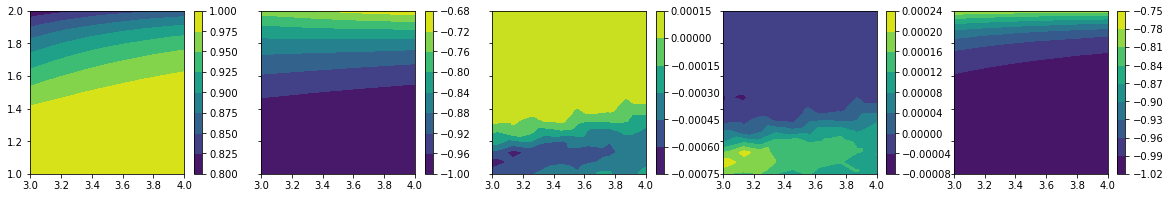

In [13]:
# visualize all invariants
grid_x, grid_y = np.mgrid[3:4:100j, 1:2:100j]
fig, axs = plt.subplots(1,5, figsize=(20,3), sharex=True, sharey=True)

for i in range(5):
    grid_inv = griddata(grid, inv_scaled.detach().numpy()[:,i], (grid_x, grid_y), method='linear')
    inv_plt = axs.flat[i].contourf(grid_x, grid_y, grid_inv)
    fig.colorbar(inv_plt, ax=axs.flat[i])

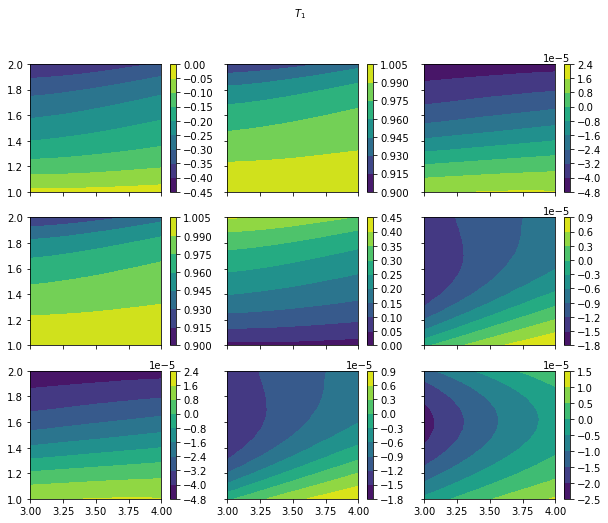

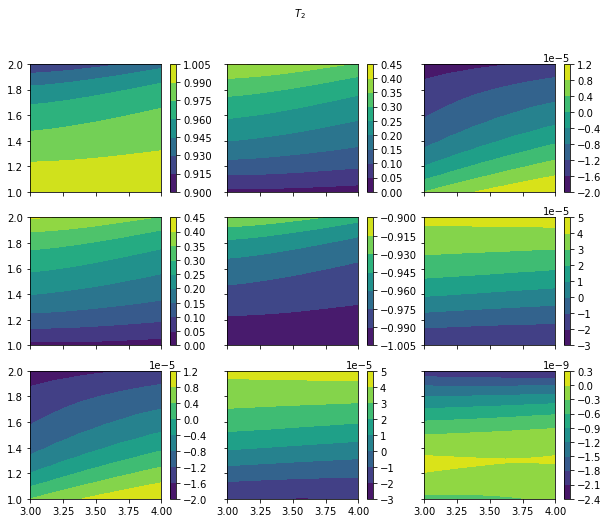

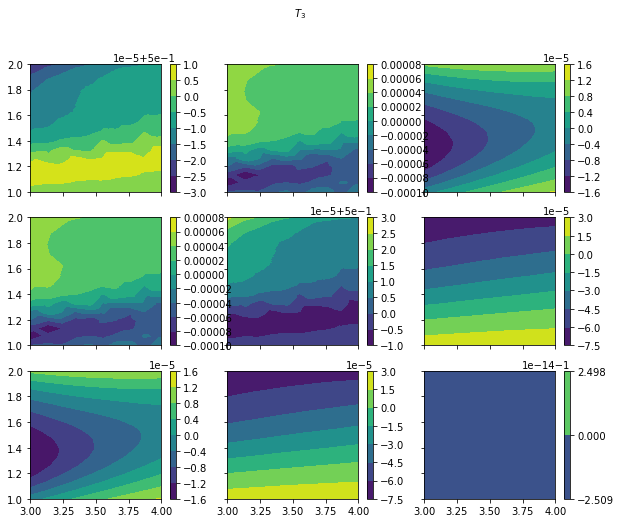

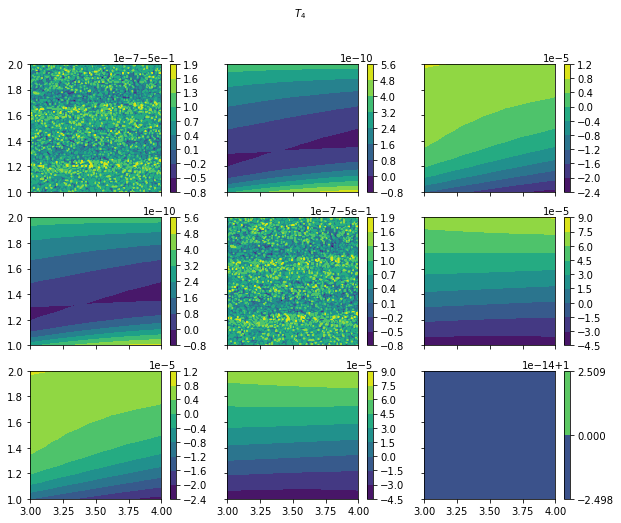

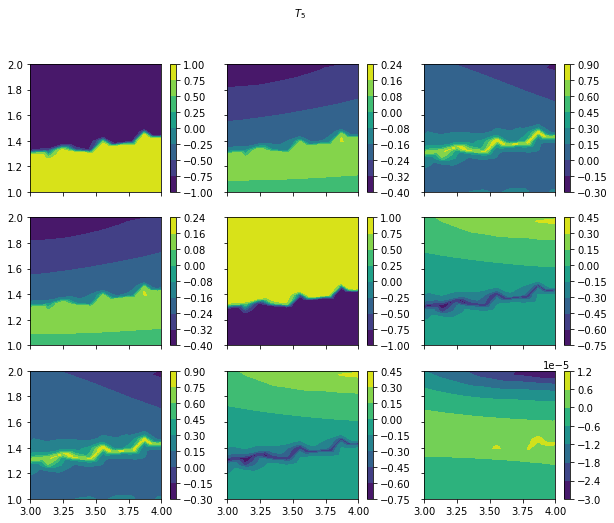

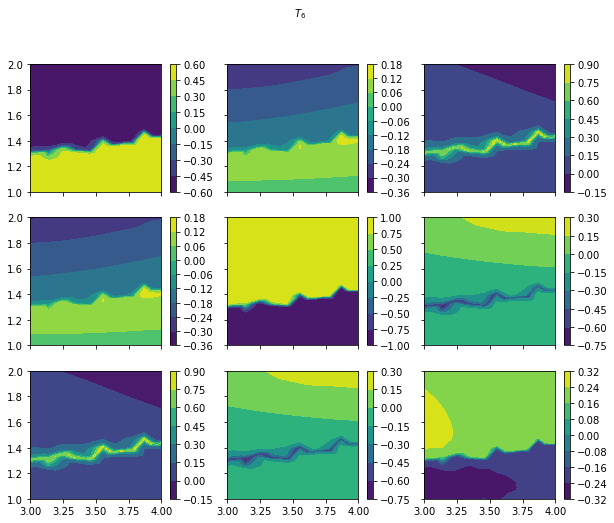

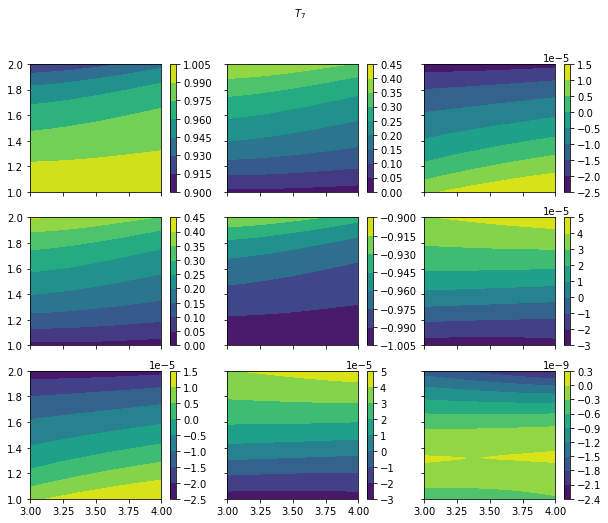

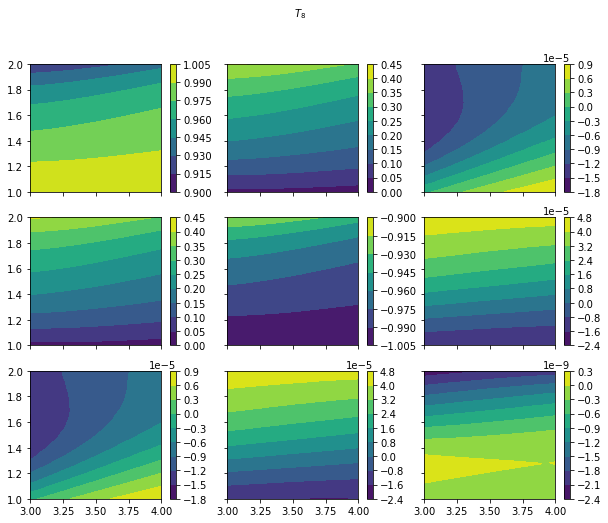

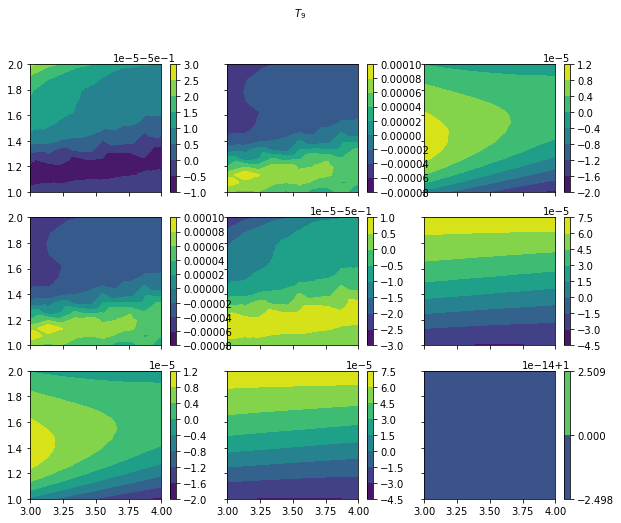

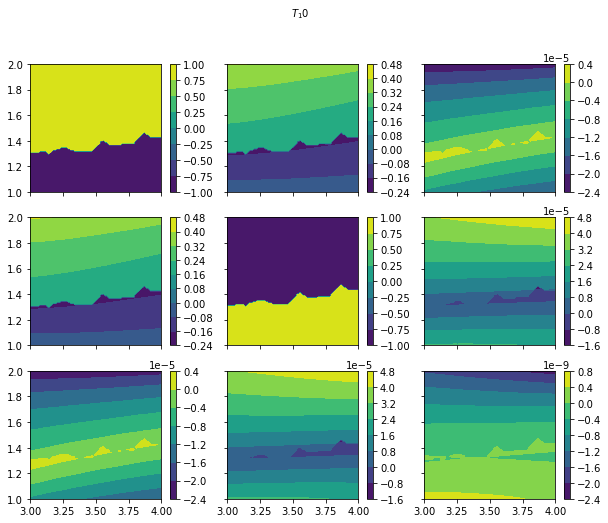

In [14]:
# visualize all tensor components of the tensor basis
grid_x, grid_y = np.mgrid[3:4:100j, 1:2:100j]

for j in range(10):
    fig, axs = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
    fig.suptitle(r'$T_{}$'.format(j+1), fontsize=10)
    for i in range(9):
        grid_z1 = griddata(grid, T.detach().numpy()[:,j,i], (grid_x, grid_y), method='linear')
        T_plt = axs.flat[i].contourf(grid_x, grid_y, grid_z1)
        fig.colorbar(T_plt, ax=axs.flat[i])

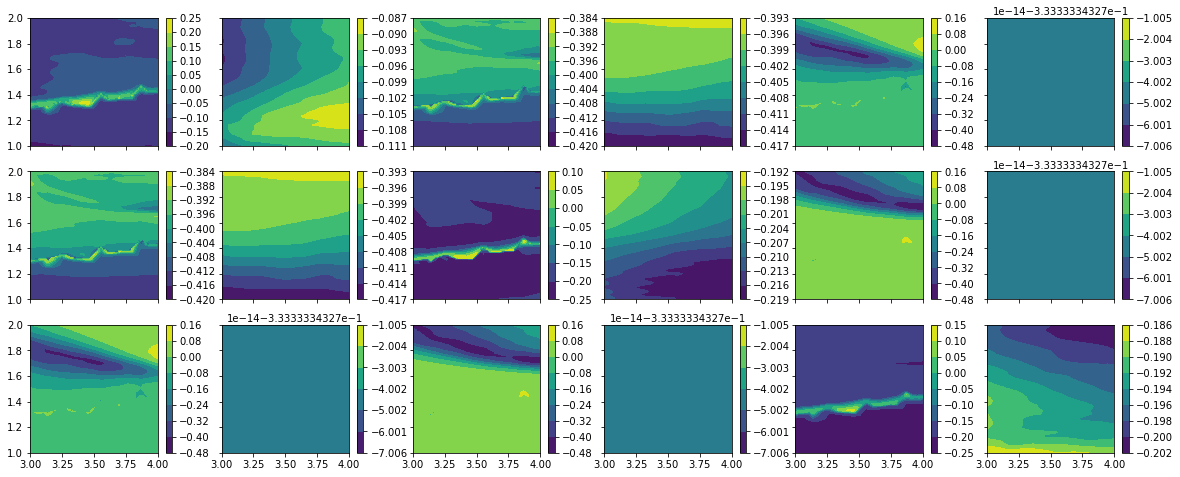

In [15]:
# visualize all tensor components of b_pred (uneven index) and b (even index)
# index runs through one line of the figure after another
grid_x, grid_y = np.mgrid[3:4:100j, 1:2:100j]
fig, axs = plt.subplots(3,6, figsize=(20,8), sharex=True, sharey=True)

for i in range(9):
    grid_z1 = griddata(grid, b_pred.detach().numpy()[:,i], (grid_x, grid_y), method='linear')
    grid_z2 = griddata(grid, b.detach().numpy()[:,i], (grid_x, grid_y), method='linear')
    R_nn = axs.flat[2*i].contourf(grid_x, grid_y, grid_z1)
    R_dns = axs.flat[2*i+1].contourf(grid_x, grid_y, grid_z2)
    fig.colorbar(R_nn, ax=axs.flat[2*i])
    fig.colorbar(R_dns, ax=axs.flat[2*i+1])

In [16]:
# class TBNN_generic(nn.Module):
#     """
#     An implementation of a fully connected feed forward 
#     Neural network in pytorch. 
#     """
#     def __init__(self, layersizes=[1, 1], 
#                  activation=torch.relu,
#                  final_layer_activation=None):
#         """
#         INPUTS:
#             layersizes <list/tuple>: An iterable ordered object containing
#                                  the sizes of the tensors from the
#                                  input layer to the final output. 
#                                  (See example below). 
#             activation <callable>: A python callable through which
#                                     torch backpropagation is possible.
#             final_layer_activation <callable>: A python callable for 
#                                     the final layer activation function.
#                                     Default: None (for regression problems)
        
#         EXAMPLE: 
#             To define a NN with an input of size 2, 2 hidden layers of size 
#             50 and 50, output of size 1, with tanh activation function: 
#             >> layers = [2, 50, 50, 1]
#             >> neuralnet = NeuralNet(layers, activation=torch.tanh)
#             >> x = torch.randn(100, 2)   # 100 randomly sampled inputs 
#             >> output = neuralnet(x)  # compute the prediction at x.
        
#         Inheriting from nn.Module ensures that all
#         NN layers defined within the __init__ function are captured and 
#         stored in an OrderedDict object for easy accesability.
#         """
#         super(TBNN_generic, self).__init__()
#         self.layersizes = layersizes
#         self.input_dim = self.layersizes[0]
#         self.hidden_sizes = self.layersizes[1:-1]
#         self.output_dim = self.layersizes[-1]
#         self.activation = activation
#         self.final_layer_activation = final_layer_activation
#         if self.final_layer_activation is None:
#             self.final_layer_activation = nn.Identity()
#         self.nlayers = len(self.hidden_sizes) + 1
#         self.layernames = [] ## Dictionary to store all the FC layers 
        
#         # define FC layers
#         for i in range(self.nlayers):
#             layername = 'fc_{}'.format(i+1)
#             layermodule = nn.Linear(self.layersizes[i], self.layersizes[i+1])
#             self.layernames.append(layername)
#             setattr(self, layername, layermodule)
        
#     def forward(self, inv, T):
#         """
#         Implement the forward pass of the NN. 
#         """
#         for i, layername in enumerate(self.layernames):
#             fclayer = getattr(self, layername)
#             inv = fclayer(inv)
#             if i == self.nlayers - 1:
#                 inv = self.final_layer_activation(inv)
#             else:
#                 inv = self.activation(inv)
                
#         G = inv.unsqueeze(2).expand(inv.shape[0],10,9)
#         return (G*T).sum(dim=1)
    
# model_2 = TBNN_generic([D_in, H, H, int(H/2), int(H/4), D_out], torch.tanh)
# # for m in model_2.modules():
# #     print(m)
